In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
#Duomenu nuskaitymo funkcija
def readFile(data_dir):
    data = pd.read_csv(data_dir, parse_dates=['Local time'], dayfirst=True)
    data = data.set_index('Local time')
    return data

bmw_data = readFile('bmw_daily.csv')
bmw_data.head()


,Open,High,Low,Close,Volume
Local time,,,,,
2021-04-13 00:00:00+03:00,88.944,89.527,88.363,88.408,1258.0518
2021-04-14 00:00:00+03:00,87.990,88.044,86.875,87.270,1310.0478
2021-04-15 00:00:00+03:00,87.255,87.878,87.068,87.496,1014.1120
2021-04-16 00:00:00+03:00,87.488,88.827,87.456,88.343,1265.6683
2021-04-17 00:00:00+03:00,88.343,88.343,88.343,88.343,0.0000


In [ ]:
#paruosiam indikatoriu rezius
def calculate_indicators(data, window):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['StdDev'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (data['StdDev'] * 2)
    data['Lower Band'] = data['SMA'] - (data['StdDev'] * 2)
    return data

#funkcija isvalanti nulius, Nan reiksmes, modifikuojant iskart duomenis.
def clean_data(data):
    data.dropna(inplace=True)
    return data

#pagrindine signalu generavimo funkcija
def generate_signals(data, trading_costs, take_profit_percentage):
    buy_signals = np.zeros(len(data), dtype=bool)
    sell_signals = np.zeros(len(data), dtype=bool)
    take_profit_signals = np.zeros(len(data), dtype=bool)
    profits = []
    cumulative_profit = [0]
    trade_dates = []
    reasons = []
    wait_for = 'buy'
    last_buy_price = None

    for i in range(len(data)):
        if wait_for == 'buy' and data['Close'].iloc[i] < data['Lower Band'].iloc[i]:
            buy_signals[i] = True
            last_buy_price = data['Close'].iloc[i] * (1 + trading_costs)
            reasons.append(f"Buy signal on {data.index[i].date()} because price {data['Close'].iloc[i]:.2f} is below the Lower Band {data['Lower Band'].iloc[i]:.2f}.")
            wait_for = 'sell'
        elif wait_for == 'sell':
            if last_buy_price is not None and data['Close'].iloc[i] >= last_buy_price * (1 + take_profit_percentage):
                take_profit_signals[i] = True
                sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                profit = sell_price - last_buy_price
                profits.append(profit)
                cumulative_profit.append(cumulative_profit[-1] + profit)
                trade_dates.append(data.index[i])
                reasons.append(f"Take profit on {data.index[i].date()} at price {data['Close'].iloc[i]:.2f} after achieving the target from buy price {last_buy_price:.2f}.")
                wait_for = 'buy'
            elif data['Close'].iloc[i] > data['Upper Band'].iloc[i]:
                sell_signals[i] = True
                if last_buy_price is not None:
                    sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                    profit = sell_price - last_buy_price
                    profits.append(profit)
                    cumulative_profit.append(cumulative_profit[-1] + profit)
                    trade_dates.append(data.index[i])
                    reasons.append(f"Sell signal on {data.index[i].date()} because price {data['Close'].iloc[i]:.2f} is above the Upper Band {data['Upper Band'].iloc[i]:.2f}.")
                wait_for = 'buy'
    return data, buy_signals, sell_signals, take_profit_signals, profits, cumulative_profit, trade_dates, reasons

#Sandriu grafiko piesimas
def plot_signals(data, buy_signals, sell_signals, take_profit_signals):
    plt.figure(figsize=(24, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
    plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    plt.plot(data.index, data['SMA'], label='SMA', linestyle='-', color='gray')
    plt.plot(data.index[buy_signals], data['Close'][buy_signals], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(data.index[sell_signals], data['Close'][sell_signals], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.plot(data.index[take_profit_signals], data['Close'][take_profit_signals], '*', markersize=10, color='gold', lw=0, label='Take Profit Signal')
    plt.xlim(data.index.min(), data.index.max())
    plt.title('Sandoriu grafikas BMW')
    plt.xlabel('Data')
    plt.ylabel('Kaina ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

#Priezasciu isprintinimas
def print_reasons(reasons):
    for reason in reasons:
        print(reason)

#Profito kitimo grafikas
def plot_profits(trade_dates, cumulative_profit):
    plt.figure(figsize=(14, 7))
    plt.plot(trade_dates, cumulative_profit[1:], label='Cumulative Profit', color='purple')
    plt.title('Pelno kitimo grafikas')
    plt.xlabel('Data')
    plt.ylabel('Pelnas ($)')
    plt.grid(True)
    plt.legend()
    plt.show()


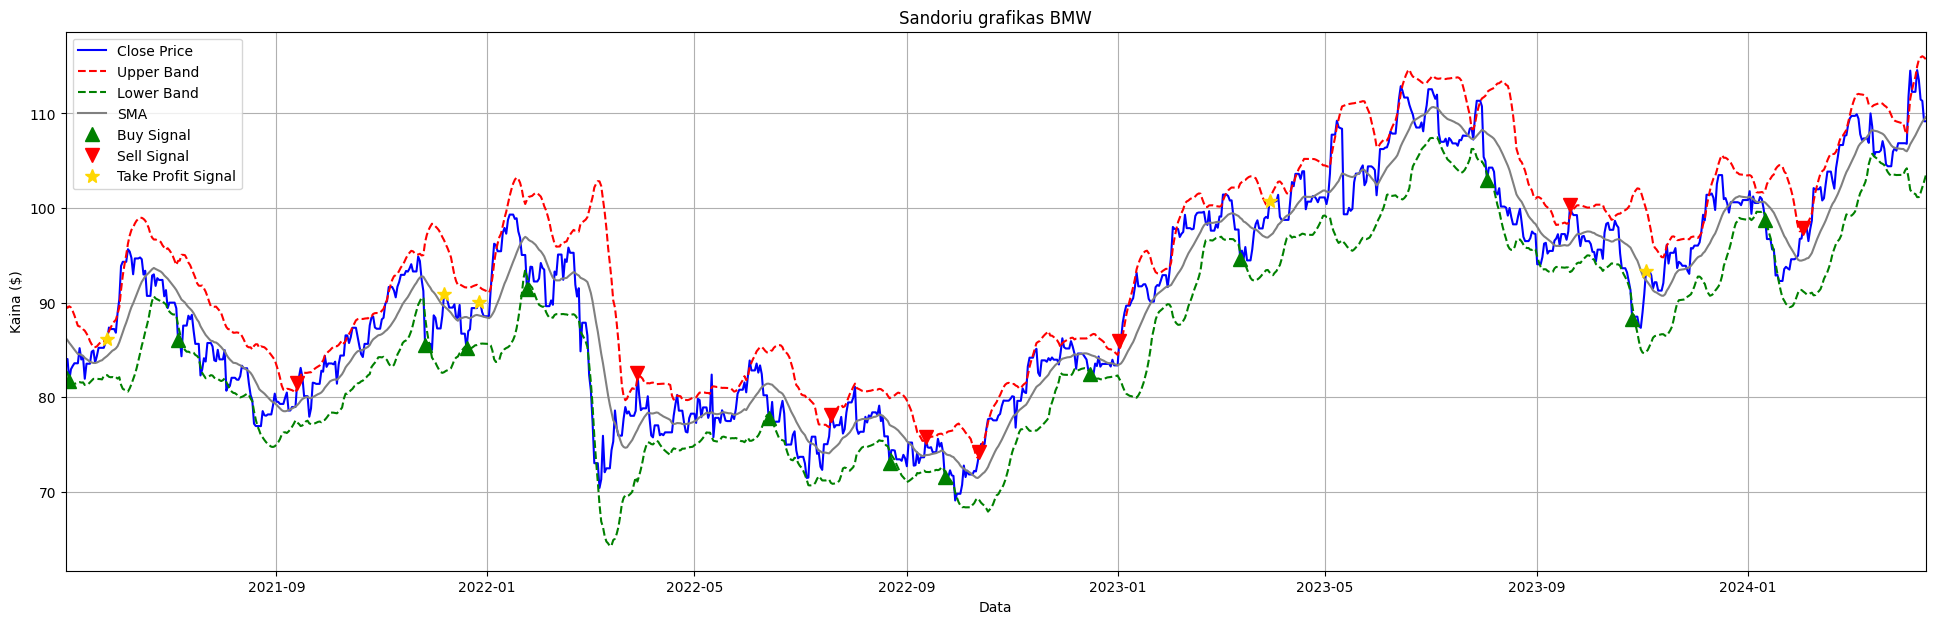

Buy signal on 2021-05-04 because price 81.73 is below the Lower Band 81.87.
Take profit on 2021-05-26 at price 86.14 after achieving the target from buy price 81.77.
Buy signal on 2021-07-06 because price 86.08 is below the Lower Band 87.55.
Sell signal on 2021-09-13 because price 81.53 is above the Upper Band 80.97.
Buy signal on 2021-11-26 because price 85.48 is below the Lower Band 88.48.
Take profit on 2021-12-07 at price 90.95 after achieving the target from buy price 85.52.
Buy signal on 2021-12-20 because price 85.14 is below the Lower Band 85.35.
Take profit on 2021-12-27 at price 90.08 after achieving the target from buy price 85.18.
Buy signal on 2022-01-24 because price 91.47 is below the Lower Band 92.77.
Sell signal on 2022-03-29 because price 82.56 is above the Upper Band 82.01.
Buy signal on 2022-06-13 because price 77.81 is below the Lower Band 78.13.
Sell signal on 2022-07-19 because price 78.12 is above the Upper Band 77.54.
Buy signal on 2022-08-22 because price 73.0

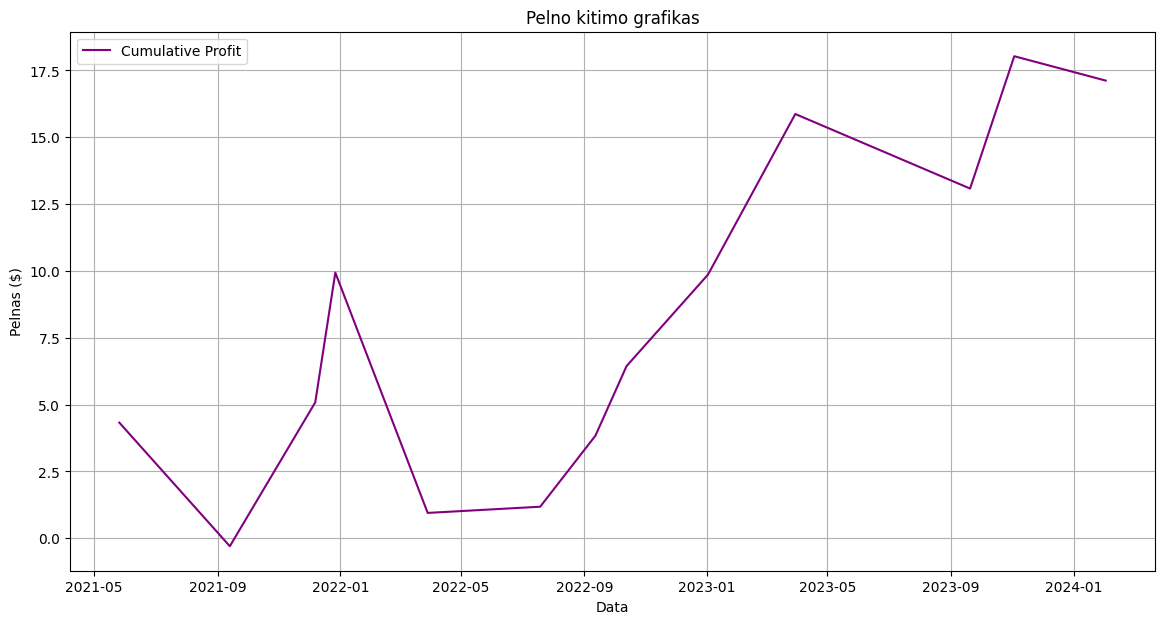

Final cumulative profit: 17.12272750000008


In [ ]:
data = readFile('bmw_daily.csv')
data = calculate_indicators(data,20)
data = clean_data(data)
data, buy_signals, sell_signals, take_profit_signals, profits, cumulative_profit, trade_dates, reasons = generate_signals(data,0.0005,0.05)
plot_signals(data, buy_signals, sell_signals, take_profit_signals)
print_reasons(reasons)
plot_profits(trade_dates, cumulative_profit)
print("Final cumulative profit:", cumulative_profit[-1])


**Optimization**

In [ ]:
#simuliacinis signalu generavimas
def simulate_trading(data, window, take_profit_percentage, trading_costs=0.0005):


    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['StdDev'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (data['StdDev'] * 2)
    data['Lower Band'] = data['SMA'] - (data['StdDev'] * 2)
    data = data.dropna()



    buy_signals = np.zeros(len(data), dtype=bool)
    sell_signals = np.zeros(len(data), dtype=bool)
    take_profit_signals = np.zeros(len(data), dtype=bool)
    profits = []
    cumulative_profit = [0]
    wait_for = 'buy'
    last_buy_price = None

    for i in range(len(data)):
        if wait_for == 'buy' and data['Close'].iloc[i] < data['Lower Band'].iloc[i]:
            buy_signals[i] = True
            last_buy_price = data['Close'].iloc[i] * (1 + trading_costs)
            wait_for = 'sell'
        elif wait_for == 'sell':
            if last_buy_price is not None and data['Close'].iloc[i] >= last_buy_price * (1 + take_profit_percentage):
                take_profit_signals[i] = True
                sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                profit = sell_price - last_buy_price
                profits.append(profit)
                cumulative_profit.append(cumulative_profit[-1] + profit)
                wait_for = 'buy'
            elif data['Close'].iloc[i] > data['Upper Band'].iloc[i]:
                sell_signals[i] = True
                if last_buy_price is not None:
                    sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                    profit = sell_price - last_buy_price
                    profits.append(profit)
                    cumulative_profit.append(cumulative_profit[-1] + profit)
                    wait_for = 'buy'

    # Sharpe Ratio skaiciavimas
    returns = np.array(profits)
    if len(returns) > 0:
        sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else 0
    else:
        sharpe_ratio = 0

    return {
        'cumulative_profit': cumulative_profit[-1],
        'sharpe_ratio': sharpe_ratio,
    }


# Nustatom rezius, reikalingus optimizacijos paieskai
window_range = range(10, 50, 5)
take_profit_range = np.arange(0.02, 0.11, 0.01)

# Kintamieji skirti rasti geriausiems parametrams
best_sharpe_ratio = 0
best_parameters = {}
best_profit = 0

# Brute-force, skirtas geriausu parametru radimui
for window in window_range:
    for take_profit in take_profit_range:
        result = simulate_trading(bmw_data.copy(), window=window, take_profit_percentage=take_profit)
        # Update'inam geriausius parametrus ir juos saugom
        if result['sharpe_ratio'] > best_sharpe_ratio:
            best_sharpe_ratio = result['sharpe_ratio']
            best_parameters = {'window': window, 'take_profit_percentage': take_profit}
            best_profit = result['cumulative_profit']

print("Best parameters:", best_parameters)
print("Sharpe ratio:", best_sharpe_ratio)
print("Best_profit:", best_profit)


Best parameters: {'window': 30, 'take_profit_percentage': 0.02}
Sharpe ratio: 1.2755661021124656
Best_profit: 34.19551700000012


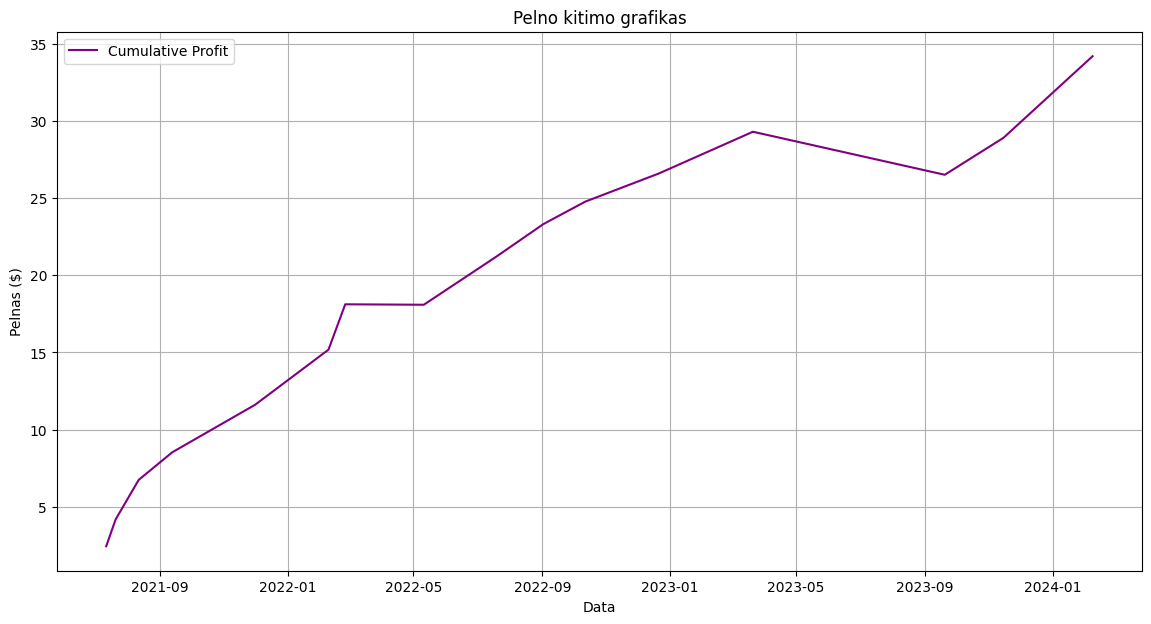

Final cumulative profit: 34.19551700000012


In [ ]:
data = readFile('bmw_daily.csv')
data = calculate_indicators(data,30)
data = clean_data(data)
data, buy_signals, sell_signals, take_profit_signals, profits, cumulative_profit, trade_dates, reasons = generate_signals(data,0.0005,0.02)
plot_profits(trade_dates, cumulative_profit)
print("Final cumulative profit:", cumulative_profit[-1])
